In [11]:
import sys
sys.path.append('..')

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from src.DataLoader import create_dataloader
from src.model import Unet
from src.utils import calculate_val_loss
 


In [14]:
class Args:
    data_path = '../spectrograms/musdb18/train'
    batch_size = 32
    epochs = 160
    checkpoint_dir = '../checkpoints/musdb18_V2'
    load_model = '../checkpoints/musdb18_V2/model_last.pth'
args = Args()

In [15]:
train_loader = create_dataloader(
    data_path=args.data_path,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=0
)

print(f"Total samples: {len(train_loader.dataset)}")
print(f"Total batches per epoch: {len(train_loader)}")


Total samples: 100
Total batches per epoch: 4


In [16]:
model = Unet()

# Load pretrained model if specified
if args.load_model:
    model.load(args.load_model)
    


Loading model from ../checkpoints/musdb18_V2/model_last.pth
Model loaded successfully!


In [17]:
%time
train_losses = []

for epoch in range(args.epochs):
    print(f"\n{'='*30}")
    print(f"Epoch {epoch+1}/{args.epochs}")
    print(f"{'='*30}")
    
    epoch_losses = []
    
    
    for i, (mix, voc) in enumerate(train_loader):

        mix, voc = mix.to(model.device), voc.to(model.device)  
        
        # Train
        loss = model.backward(mix, voc)
        epoch_losses.append(loss)
        
        if (i+1) % 10 == 0:
            avg_loss = sum(epoch_losses[-10:]) / len(epoch_losses[-10:])
            print(f"Batch {i+1}/{len(train_loader)} - Loss: {avg_loss:.6f}")
    
    # Epoch summary
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Average Loss: {avg_epoch_loss:.6f}")
    train_losses.append(avg_epoch_loss)
    
    # Save checkpoint
    checkpoint_path = os.path.join(args.checkpoint_dir, f'model_epoch_{epoch+1}.pth')
    model.save(checkpoint_path)
    
    # Always save the latest with model_last name !
    latest_path = os.path.join(args.checkpoint_dir, 'model_last.pth')
    model.save(latest_path)

np.save('../checkpoints/musdb18_V2/train_losses_32.npy', train_losses)



CPU times: total: 0 ns
Wall time: 1 ms

Epoch 1/160

Epoch 1 Summary:
Average Loss: 0.002554
Model saved to ../checkpoints/musdb18_V2\model_epoch_1.pth
Model saved to ../checkpoints/musdb18_V2\model_last.pth

Epoch 2/160

Epoch 2 Summary:
Average Loss: 0.002580
Model saved to ../checkpoints/musdb18_V2\model_epoch_2.pth
Model saved to ../checkpoints/musdb18_V2\model_last.pth

Epoch 3/160

Epoch 3 Summary:
Average Loss: 0.002948
Model saved to ../checkpoints/musdb18_V2\model_epoch_3.pth
Model saved to ../checkpoints/musdb18_V2\model_last.pth

Epoch 4/160

Epoch 4 Summary:
Average Loss: 0.002675
Model saved to ../checkpoints/musdb18_V2\model_epoch_4.pth
Model saved to ../checkpoints/musdb18_V2\model_last.pth

Epoch 5/160

Epoch 5 Summary:
Average Loss: 0.002669
Model saved to ../checkpoints/musdb18_V2\model_epoch_5.pth
Model saved to ../checkpoints/musdb18_V2\model_last.pth

Epoch 6/160

Epoch 6 Summary:
Average Loss: 0.002600
Model saved to ../checkpoints/musdb18_V2\model_epoch_6.pth
Mod

In [19]:
# calculate loss for valid data 

val_loader = create_dataloader(
    data_path='../spectrograms/musdb18/valid',  
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=0
)

checkpoint_dir = '../checkpoints/musdb18_V2'
val_losses = []

print("Calculating validation losses for all checkpoints...")

for epoch in range(1, args.epochs + 1):
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pth')
    
    if os.path.exists(checkpoint_path):
        # Load model
        model = Unet()
        model.load(checkpoint_path)
        
        # Calculate val loss
        val_loss = calculate_val_loss(model, val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch:2d}: Val Loss = {val_loss:.6f}")


np.save('../checkpoints/musdb18_V2/validation_losses_32batch.npy', val_losses)



Calculating validation losses for all checkpoints...
Loading model from ../checkpoints/musdb18_V2\model_epoch_1.pth
Model loaded successfully!
Epoch  1: Val Loss = 0.002792
Loading model from ../checkpoints/musdb18_V2\model_epoch_2.pth
Model loaded successfully!
Epoch  2: Val Loss = 0.002449
Loading model from ../checkpoints/musdb18_V2\model_epoch_3.pth
Model loaded successfully!
Epoch  3: Val Loss = 0.002855
Loading model from ../checkpoints/musdb18_V2\model_epoch_4.pth
Model loaded successfully!
Epoch  4: Val Loss = 0.002923
Loading model from ../checkpoints/musdb18_V2\model_epoch_5.pth
Model loaded successfully!
Epoch  5: Val Loss = 0.002722
Loading model from ../checkpoints/musdb18_V2\model_epoch_6.pth
Model loaded successfully!
Epoch  6: Val Loss = 0.002711
Loading model from ../checkpoints/musdb18_V2\model_epoch_7.pth
Model loaded successfully!
Epoch  7: Val Loss = 0.002386
Loading model from ../checkpoints/musdb18_V2\model_epoch_8.pth
Model loaded successfully!
Epoch  8: Val Los

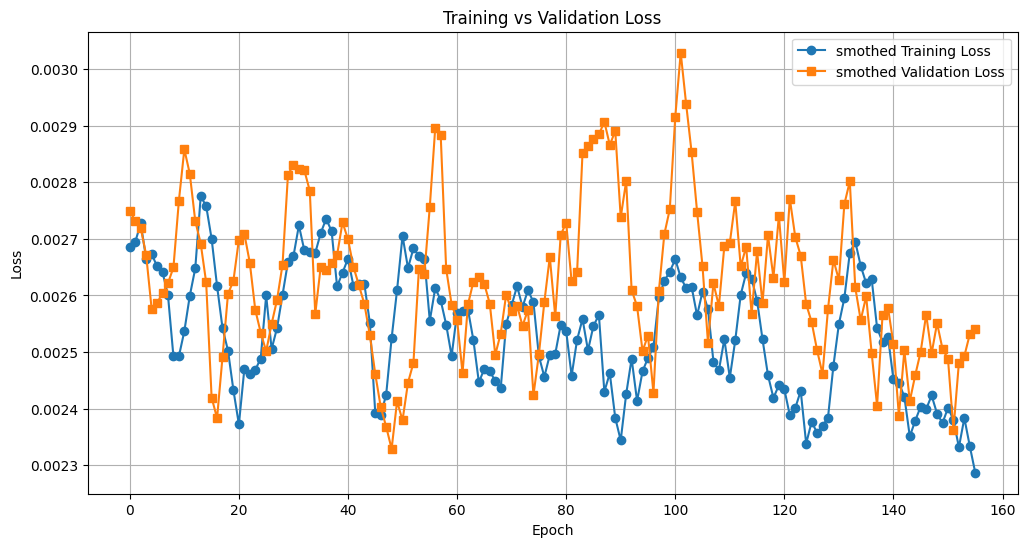

In [25]:
# import and plot the losses 
train_losses = np.load('../checkpoints/musdb18_V2/train_losses_32.npy')
val_losses = np.load('../checkpoints/musdb18_V2/validation_losses_32batch.npy')

# smothe the curves 

train_losses_s = np.convolve(train_losses, np.ones(5)/5, mode='valid')
val_losses_s = np.convolve(val_losses, np.ones(5)/5, mode='valid')



plt.figure(figsize=(12, 6))
plt.plot( train_losses_s, label='smothed Training Loss', marker='o')
plt.plot( val_losses_s, label='smothed Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
# plt.savefig('../checkpoints/musdb18_V2/loss_curve_160_epoch_batch_32.png')